<a href="https://colab.research.google.com/github/nickocruzm/Research299/blob/main/SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import warnings
from google.colab import userdata

warnings.simplefilter(action='ignore', category=FutureWarning)
userdata.get('HF_TOKEN')


if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f'device: {device}')

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to(device)

device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt = ""
image = pipe(prompt).images[0]
image

Different Pipeline below, Simplified and Explicit.

In [ ]:
import torch
import torch.nn.functional as F
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionPipeline
)
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'device: {device}')


# 1. Load pretrained components (Stable Diffusion v1.5)

model_id = "runwayml/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)


device: cuda


In [ ]:

# The scheduler defines how noise is added and removed
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")


# 2. (Training Phase) Encode real image and add noise
# Load an image from disk (example)
image = Image.open("flower.png").convert("RGB").resize((512, 512))


In [ ]:
torch.Tensor((torch.FloatTensor(torch.ByteTensor(bytearray(image.tobytes())).view(512,512,3).numpy())/255.0))

tensor([[[0.1255, 0.1294, 0.1373],
         [0.1255, 0.1294, 0.1373],
         [0.1255, 0.1294, 0.1373],
         ...,
         [0.1255, 0.1294, 0.1373],
         [0.1412, 0.1412, 0.1490],
         [0.2000, 0.2000, 0.2000]],

        [[0.1255, 0.1294, 0.1373],
         [0.1255, 0.1294, 0.1373],
         [0.1255, 0.1294, 0.1373],
         ...,
         [0.1255, 0.1294, 0.1373],
         [0.1412, 0.1412, 0.1490],
         [0.2000, 0.2000, 0.2000]],

        [[0.1255, 0.1294, 0.1373],
         [0.1255, 0.1294, 0.1373],
         [0.1255, 0.1294, 0.1373],
         ...,
         [0.1255, 0.1294, 0.1373],
         [0.1412, 0.1412, 0.1490],
         [0.2000, 0.2000, 0.2000]],

        ...,

        [[0.1176, 0.1961, 0.1490],
         [0.1176, 0.1961, 0.1490],
         [0.1176, 0.1961, 0.1490],
         ...,
         [0.1137, 0.1961, 0.1490],
         [0.1333, 0.1961, 0.1569],
         [0.2000, 0.2000, 0.2000]],

        [[0.1176, 0.1961, 0.1490],
         [0.1176, 0.1961, 0.1490],
         [0.

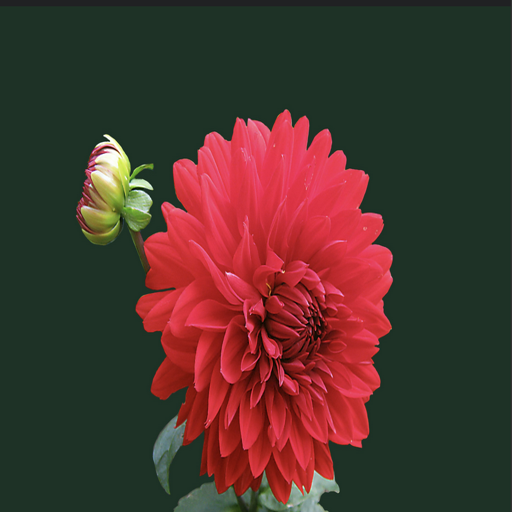

In [ ]:
image

In [ ]:
image_tensor = torch.tensor((torch.FloatTensor(torch.ByteTensor(bytearray(image.tobytes())).view(512, 512, 3).numpy()) / 255.0))

image_tensor = image_tensor.permut(2,0,1).unsqueeze(0).to(device)

image_tensor.shape

/tmp/ipython-input-1245702875.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(


torch.Size([1, 3, 512, 512])

In [ ]:
# VAE encodes RGB → latent space
with torch.no_grad():
    latent_dist = vae.encode(image_tensor * 2 - 1).latent_dist
    latents = latent_dist.sample() * 0.18215   # scaled latent


In [ ]:
# Encode text prompt
prompt = "a flower"
text_inputs = tokenizer(prompt, return_tensors="pt", padding="max_length",
                        max_length=tokenizer.model_max_length, truncation=True).to(device)
with torch.no_grad():
    text_embeds = text_encoder(**text_inputs).last_hidden_state



In [ ]:
# Add noise using scheduler (forward process)
noise = torch.randn_like(latents)
timesteps = torch.randint(0, scheduler.num_train_timesteps, (1,), device=device, dtype=torch.long)
noisy_latents = scheduler.add_noise(latents, noise, timesteps)

# U-Net predicts the added noise
predicted_noise = unet(noisy_latents, timesteps, text_embeds).sample

# Compute loss (what gets optimized in training)
loss = F.mse_loss(predicted_noise, noise)
print(f"Training loss: {loss.item():.6f}")



Training loss: 0.060379


In [ ]:
# (In real training, you would now call loss.backward() and optimizer.step())

# ----------------------------------------------------------
# 3. (Inference Phase) Generate new image from random noise
# ----------------------------------------------------------

# You can use the pipeline for easier inference
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
pipe = pipe.to(device)

prompt = "Harit Talwar"
with torch.autocast("cuda"):
    image = pipe(prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

image.save("Harit.png")
print("Saved generated_image.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Saved generated_image.png


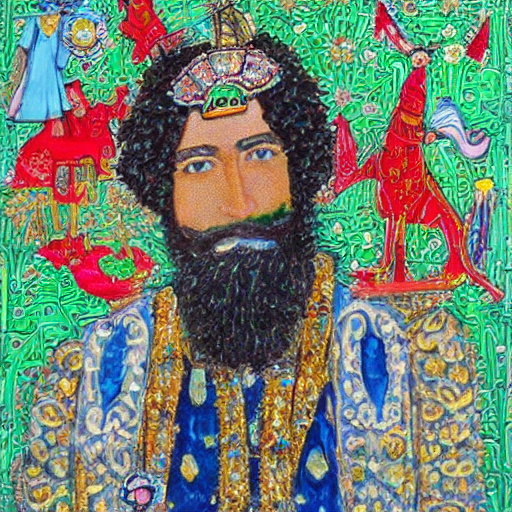

In [ ]:
image

In [ ]:
import torch
from diffusers import AutoencoderKL
import numpy as np

def encode_to_latent(image_np: np.ndarray, vae: AutoencoderKL, device: str = None) -> torch.Tensor:
    """
    Encode an RGB image (H,W,3) numpy array into Stable Diffusion latent space.

    Args:
        image_np (np.ndarray): Input image in [0,1] or [0,255] range, shape (H, W, 3).
        vae (AutoencoderKL): Pretrained VAE from Stable Diffusion.
        device (str, optional): 'cuda' or 'cpu'. Defaults to device of vae.

    Returns:
        torch.Tensor: Latent tensor of shape (1, 4, 64, 64).
    """
    if device is None:
        device = next(vae.parameters()).device

    # Ensure correct dtype and range
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # normalize if in [0,255]

    # Convert to tensor, permute to (B,C,H,W), and normalize to [-1,1]
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0).float().to(device)
    image_tensor = image_tensor * 2 - 1

    with torch.no_grad():
        latent_dist = vae.encode(image_tensor).latent_dist
        latents = latent_dist.sample() * 0.18215  # scale factor used in SD

    return latents

Latent shape: torch.Size([1, 4, 64, 64])


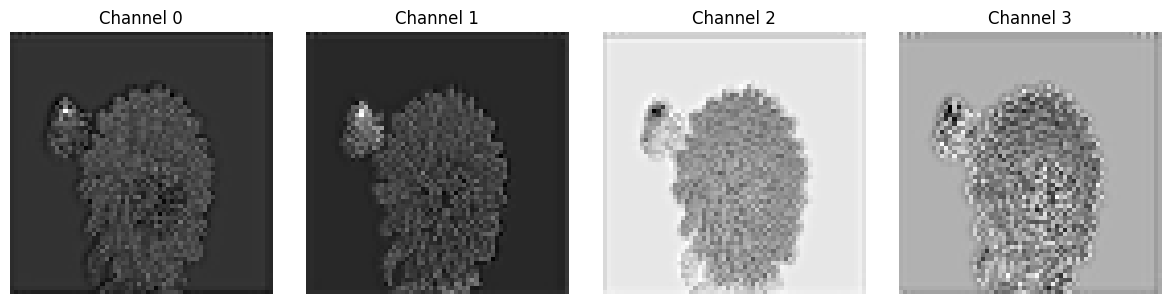

In [ ]:
from diffusers import AutoencoderKL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the pretrained Stable Diffusion VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to("cuda" if torch.cuda.is_available() else "cpu")

# Load image
image = Image.open("flower.png").convert("RGB").resize((512, 512))
image_np = np.array(image).astype(np.float32) / 255.0

# Get latent representation
latents = encode_to_latent(image_np, vae)
print("Latent shape:", latents.shape)

# Visualize the latent channels
latents_np = latents[0].detach().cpu().numpy()
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(latents_np[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Channel {i}")
plt.tight_layout()
plt.show()